# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

## **1. Data Acquisition**
Load the CSV file turn it into a dataframe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
import sys
from pathlib import Path

# Add the base path to sys.path
BASE_DIR = Path().resolve().parent
sys.path.append(str(BASE_DIR / 'core'))

# Now you can import the modules
from core.classes.CheckMissingValues import DataCleaning
from core.classes.FlightPerformance import FlightPerformance
from core.classes.Multicollinearity import Multicollinearity
from core.classes.NewFeatures import NewFeatures

from core.functions import *
from core.config import EXCEL_FILE, CSV_FILE_SCHED, CSV_FILE_WEATHER
from core.utils import *

In [3]:
# Construct full paths for the data files using BASE_DIR
csv_file_sched_path = BASE_DIR / 'data' / 'avStats_schedule_historical_2023_BRU.csv'
csv_file_weather_path = BASE_DIR / 'data' / 'BRU2023_weather.csv'
excel_file_path = BASE_DIR / 'data' / 'avia_par_be_page_spreadsheet.xlsx'

# Read the data files
df_avstats = pd.read_csv(csv_file_sched_path)
df_weather = pd.read_csv(csv_file_weather_path)
df_passengers = pd.ExcelFile(excel_file_path)

# Display the first few rows of the avstats dataframe
df_avstats.head()

C:\Testing\Anaconda\envs\DTCS\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,aat,airline_name,cargo,private,airline_iata_code,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00,2023-08-15 14:12:00+00,CPH,2023-08-15 15:30:00+00,2023-08-15 15:17:00+00,SAS,False,False,SK,SK1594,90.0,65.0,754.4
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00,2023-08-15 14:10:00+00,BRU,2023-08-15 16:55:00+00,2023-08-15 16:43:00+00,ROYAL AIR MAROC,False,False,AT,AT1688,175.0,153.0,1864.7
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00,2023-08-15 14:12:00+00,CPH,2023-08-15 15:30:00+00,NaN,SAS,False,False,SK,SK1594,90.0,NaN,754.4
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00,2023-08-15 14:27:00+00,BRU,2023-08-15 16:20:00+00,2023-08-15 16:22:00+00,BRUSSELS AIRLINES,False,False,SN,SN3778,135.0,115.0,1359.5
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00,2023-08-15 15:34:00+00,BRU,2023-08-15 16:55:00+00,NaN,TAROM,False,False,RO,RO373,170.0,NaN,1754.8


## **2. Data Cleaning & Processing**
* Check for duplicates
* Handle missing values
* Create new features

### **2.1. Duplicates & Missing Values**

These are the changes made to fill out all the missing values in the dataset.
* Delay minutes NaN -> 0
* Actual departure time (adt) NaN -> Calculate it based on scheduled departure time (sdt) and delay minutes
* Actual arrival time (aat) NaN -> Calculate it based on scheduled arrival time (sat) and delay minutes
* When private flight -> Airline code and flight number as NONE
* Calculate the NaN values for both the calculated scheduled and actual flight time

In [4]:
check = DataCleaning(unique_column='uuid')
missing_values, duplicate_rows = check.check_missing_and_duplicates(df_avstats)

Number of total missing values: 458523
Number of total duplicated rows: 0
Missing values by column:
uuid                            0
route_iata_code                 0
type                            0
status                          0
dep_iata_code                   0
dep_delay                   18454
sdt                             0
adt                         44346
arr_iata_code                   0
sat                             0
aat                        193017
airline_name                    0
cargo                           0
private                         0
airline_iata_code            4832
flight_iata_number           4832
calc_sft                        9
calc_aft                   193033
calc_flight_distance_km         0
dtype: int64


In [60]:
# Discard records with null dep_delay unless both sdt and adt are available
df_avstats = df_avstats[~(df_avstats['dep_delay'].isnull() & (df_avstats['sdt'].isnull() | df_avstats['adt'].isnull()))]

# Copy the filtered DataFrame to avoid SettingWithCopyWarning
df = df_avstats.copy()

# Convert specified columns to datetime
datetime_columns = ['sat', 'sdt', 'aat', 'adt']
df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime)

# Calculate dep_delay if both sdt and adt are available and dep_delay is still null
mask = df['dep_delay'].isnull() & df['sdt'].notnull() & df['adt'].notnull()
df.loc[mask, 'dep_delay'] = (df['adt'] - df['sdt']).dt.total_seconds() / 60  # Calculate delay in minutes

# Fill remaining dep_delay with 0 for non-delayed flights
df['dep_delay'] = df['dep_delay'].fillna(0)

# Fill missing 'adt' and 'aat' values based on their corresponding scheduled times and delays
df['adt'] = df['adt'].fillna(df['sdt'] + pd.to_timedelta(df['dep_delay'], unit='m'))
df['aat'] = df['aat'].fillna(df['sat'] + pd.to_timedelta(df['dep_delay'], unit='m'))
df['calc_sft'] = df['calc_sft'].fillna((df['sat'] - df['sdt']) / pd.Timedelta(minutes=1))
df['calc_aft'] = df['calc_aft'].fillna((df['aat'] - df['adt']) / pd.Timedelta(minutes=1))

# Fill missing airline and flight information with 'NONE'
df = df.fillna({'airline_iata_code': 'NONE', 'flight_iata_number': 'NONE'})

df.head(10)

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,sdt,adt,arr_iata_code,sat,aat,airline_name,cargo,private,airline_iata_code,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,2023-08-15 15:17:00+00:00,SAS,False,False,SK,SK1594,90.0,65.0,754.4
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,BRU,2023-08-15 16:55:00+00:00,2023-08-15 16:43:00+00:00,ROYAL AIR MAROC,False,False,AT,AT1688,175.0,153.0,1864.7
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,CPH,2023-08-15 15:30:00+00:00,2023-08-15 15:42:00+00:00,SAS,False,False,SK,SK1594,90.0,90.0,754.4
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,2023-08-15 16:22:00+00:00,BRUSSELS AIRLINES,False,False,SN,SN3778,135.0,115.0,1359.5
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,BRU,2023-08-15 16:55:00+00:00,2023-08-15 18:25:00+00:00,TAROM,False,False,RO,RO373,170.0,171.0,1754.8
5,C71A1480E0780A51C0B9174E0E8A5695BDD0CDE2,IBZ-BRU,DEPARTURE,ACTIVE,IBZ,23.0,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,BRU,2023-08-15 16:20:00+00:00,2023-08-15 16:43:00+00:00,BRUSSELS AIRLINES,False,False,SN,SN3778,135.0,136.0,1359.5
7,425B80B4EF9940D2F59108D839749E6B52696ED5,MLA-BRU,ARRIVAL,LANDED,MLA,30.0,2023-08-15 14:10:00+00:00,2023-08-15 14:40:00+00:00,BRU,2023-08-15 17:05:00+00:00,2023-08-15 17:13:00+00:00,AIR MALTA,False,False,KM,KM420,175.0,153.0,1853.6
8,884CA852266F99E514393771BA858A2F8851D5D6,BRU-ALC,DEPARTURE,ACTIVE,BRU,35.0,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,ALC,2023-08-15 16:40:00+00:00,2023-08-15 17:15:00+00:00,TRANSAVIA,False,False,HV,HV9005,150.0,151.0,1458.0
9,BD3202B4E6C1CD1DFC6ACB722D1C6500C08951F6,BRU-ALC,ARRIVAL,LANDED,BRU,35.0,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,ALC,2023-08-15 16:40:00+00:00,2023-08-15 16:49:00+00:00,TRANSAVIA,False,False,HV,HV9005,150.0,125.0,1458.0
10,65097B9852945F3990B0991781555483AE2EB102,MLA-BRU,DEPARTURE,ACTIVE,MLA,20.0,2023-08-15 14:10:00+00:00,2023-08-15 14:30:00+00:00,BRU,2023-08-15 17:05:00+00:00,2023-08-15 17:25:00+00:00,AIR MALTA,False,False,KM,KM420,175.0,175.0,1853.6


In [61]:
print(df.isna().sum().sum()) # Prints amount of missing values

0


### **2.2. New Features**

Binary column for delays (New column **dep_delay_15**)
* Categorizes flights as delayed (1) and not delayed (0)
* Its considered as a delayed flight when its > 15 minutes delayed

Categorize delays (New column **dep_delay_cat**)
* Short (under 15 minutes)
* Medium (15-60 minutes)
* Long (over 60 minutes)

Flight category (New column **flight_cat**)
* Cargo
* Commercial
* Private

Set dep & arr times into time windows (New column **dep_time_window & arr_time_window**)
* Morning (00:00 to 11:59)
* Afternoon (12:00 to 17:59)
* Night (18:00 to 23:59)

In [62]:
# Create a new column dep_delay_15
df['dep_delay_15'] = (df['dep_delay'] > 15).astype(int)

# Move dep_delay_15 next to dep_delay
cols = df.columns.tolist()
cols.insert(cols.index('dep_delay') + 1, cols.pop(cols.index('dep_delay_15')))
df = df[cols]

# Create a new column dep_delay_cat
df['dep_delay_cat'] = pd.cut(df['dep_delay'], bins=[-float('inf', ), 15, 60, float('inf')], labels=['Short', 'Medium', 'Long'])

# Move dep_delay_cat next to dep_delay_15
cols = df.columns.tolist()
cols.insert(cols.index('dep_delay_15') + 1, cols.pop(cols.index('dep_delay_cat')))
df = df[cols]

# Helper function for categorizing flight
def categorize_flight(row):
    flight = NewFeatures(uuid=row['uuid'], dep_delay=row['dep_delay'], sdt=row['sdt'], sat=row['sat'],
                         cargo=row['cargo'], private=row['private'])
    return flight.categorize_flight()


# Create a new column flight_cat using categorize_flight method
df['flight_cat'] = df.apply(categorize_flight, axis=1)

# Helper function for getting time window
def get_time_window_for_flight(row, time_type='departure'):
    flight = NewFeatures(uuid=row['uuid'], dep_delay=row['dep_delay'], sdt=row['sdt'], sat=row['sat'],
                         cargo=row['cargo'], private=row['private'])
    return flight.get_time_window(time_type)


# Add new columns for departure and arrival time windows
df['dep_time_window'] = df.apply(get_time_window_for_flight, axis=1, time_type='departure')
df['arr_time_window'] = df.apply(get_time_window_for_flight, axis=1, time_type='arrival')

# Create a new column for on-time flights
df['on_time_15'] = (df['dep_delay'] < 15).astype(int)

df.head(10)

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,dep_delay_15,dep_delay_cat,sdt,adt,...,private,airline_iata_code,flight_iata_number,calc_sft,calc_aft,calc_flight_distance_km,flight_cat,dep_time_window,arr_time_window,on_time_15
0,D4B953A52B6B376A144AFA95DBCF5C14D7154C83,BRU-CPH,ARRIVAL,LANDED,BRU,12.0,0,Short,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,...,False,SK,SK1594,90.0,65.0,754.4,Commercial,Afternoon,Afternoon,1
1,476BC61CB63C6766B18F9AF8AF60D3A8F66FF08C,OUD-BRU,ARRIVAL,LANDED,OUD,10.0,0,Short,2023-08-15 14:00:00+00:00,2023-08-15 14:10:00+00:00,...,False,AT,AT1688,175.0,153.0,1864.7,Commercial,Afternoon,Afternoon,1
2,412CDB45D7CC4CF4C637C50D443E4649773C1787,BRU-CPH,DEPARTURE,ACTIVE,BRU,12.0,0,Short,2023-08-15 14:00:00+00:00,2023-08-15 14:12:00+00:00,...,False,SK,SK1594,90.0,90.0,754.4,Commercial,Afternoon,Afternoon,1
3,01549CD997A261C77CD8CDE664172687D13255BF,IBZ-BRU,ARRIVAL,LANDED,IBZ,23.0,1,Medium,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,...,False,SN,SN3778,135.0,115.0,1359.5,Commercial,Afternoon,Afternoon,0
4,8CBE8A849C7510077FA66B228920701423E8C976,OTP-BRU,ARRIVAL,SCHEDULED,OTP,90.0,1,Long,2023-08-15 14:05:00+00:00,2023-08-15 15:34:00+00:00,...,False,RO,RO373,170.0,171.0,1754.8,Commercial,Afternoon,Afternoon,0
5,C71A1480E0780A51C0B9174E0E8A5695BDD0CDE2,IBZ-BRU,DEPARTURE,ACTIVE,IBZ,23.0,1,Medium,2023-08-15 14:05:00+00:00,2023-08-15 14:27:00+00:00,...,False,SN,SN3778,135.0,136.0,1359.5,Commercial,Afternoon,Afternoon,0
7,425B80B4EF9940D2F59108D839749E6B52696ED5,MLA-BRU,ARRIVAL,LANDED,MLA,30.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:40:00+00:00,...,False,KM,KM420,175.0,153.0,1853.6,Commercial,Afternoon,Afternoon,0
8,884CA852266F99E514393771BA858A2F8851D5D6,BRU-ALC,DEPARTURE,ACTIVE,BRU,35.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,...,False,HV,HV9005,150.0,151.0,1458.0,Commercial,Afternoon,Afternoon,0
9,BD3202B4E6C1CD1DFC6ACB722D1C6500C08951F6,BRU-ALC,ARRIVAL,LANDED,BRU,35.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:44:00+00:00,...,False,HV,HV9005,150.0,125.0,1458.0,Commercial,Afternoon,Afternoon,0
10,65097B9852945F3990B0991781555483AE2EB102,MLA-BRU,DEPARTURE,ACTIVE,MLA,20.0,1,Medium,2023-08-15 14:10:00+00:00,2023-08-15 14:30:00+00:00,...,False,KM,KM420,175.0,175.0,1853.6,Commercial,Afternoon,Afternoon,0


### **2.2. Weather dataframe (External data)**

In [63]:
check = DataCleaning(unique_column='datetime')
missing_values, duplicate_rows = check.check_missing_and_duplicates(df_weather)

Number of total missing values: 0
Number of total duplicated rows: 0
Missing values by column:
name                0
datetime            0
tempmax             0
tempmin             0
temp                0
feelslikemax        0
feelslikemin        0
feelslike           0
dew                 0
humidity            0
precip              0
precipprob          0
precipcover         0
preciptype          0
snow                0
snowdepth           0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
uvindex             0
severerisk          0
sunrise             0
sunset              0
moonphase           0
conditions          0
description         0
icon                0
stations            0
dtype: int64


In [64]:
# Fill missing preciptype information with 'NONE'
df_weather['preciptype'] = df_weather['preciptype'].fillna('NONE')

# Ensure that datetime is in the correct format and convert to UTC if already timezone-aware
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'], errors='coerce')
if df_weather['datetime'].dt.tz is not None:
    df_weather['datetime'] = df_weather['datetime'].dt.tz_convert('UTC')
else:
    df_weather['datetime'] = df_weather['datetime'].dt.tz_localize('UTC', ambiguous='NaT')

# Sort the DataFrames before merging
df_sorted = df.sort_values('sdt')
df_weather_sorted = df_weather.sort_values('datetime')

# Merge the two DataFrames using merge_asof
df_combined_weather = pd.merge_asof(df_sorted, df_weather_sorted, left_on='sdt', right_on='datetime',
                                    direction='backward')

df_combined_weather.head()

,uuid,route_iata_code,type,status,dep_iata_code,dep_delay,dep_delay_15,dep_delay_cat,sdt,adt,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,AB07AD1346E2C4E096B6255A65C4053101CFEBAF,EWR-BRU,DEPARTURE,ACTIVE,EWR,50.0,1,Medium,2023-01-01 00:00:00+00:00,2023-01-01 00:50:00+00:00,...,2.0,2,10,2023-01-01T08:45:09,2023-01-01T16:47:08,0.31,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"E5287,06459099999,06439099999,D0152,0645009999..."
1,EFA537BFCCF2EB69EF6022999E8A09048DD3B2C7,EWR-BRU,ARRIVAL,LANDED,EWR,51.0,1,Medium,2023-01-01 00:00:00+00:00,2023-01-01 00:51:00+00:00,...,2.0,2,10,2023-01-01T08:45:09,2023-01-01T16:47:08,0.31,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"E5287,06459099999,06439099999,D0152,0645009999..."
2,AB11BF87FA896A1E809419A1726D9FF6B00AC68B,ORD-BRU,ARRIVAL,LANDED,ORD,35.0,1,Medium,2023-01-01 00:15:00+00:00,2023-01-01 00:49:00+00:00,...,2.0,2,10,2023-01-01T08:45:09,2023-01-01T16:47:08,0.31,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"E5287,06459099999,06439099999,D0152,0645009999..."
3,AC9D53F2D73297C7BA6E30ADAFB96CFCD79BF29A,ORD-BRU,DEPARTURE,ACTIVE,ORD,35.0,1,Medium,2023-01-01 00:15:00+00:00,2023-01-01 00:49:00+00:00,...,2.0,2,10,2023-01-01T08:45:09,2023-01-01T16:47:08,0.31,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"E5287,06459099999,06439099999,D0152,0645009999..."
4,482B3DF7ED4262D7119AFE5F4A6253A2D8560823,YUL-BRU,ARRIVAL,LANDED,YUL,38.0,1,Medium,2023-01-01 00:20:00+00:00,2023-01-01 00:57:00+00:00,...,2.0,2,10,2023-01-01T08:45:09,2023-01-01T16:47:08,0.31,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"E5287,06459099999,06439099999,D0152,0645009999..."


### **2.4. Passanger dataframe (External data)**

In [65]:
# Load the specific sheet for Arrival and Departure 2023
df_passengers_airline = pd.read_excel(df_passengers, sheet_name='Sheet 1', header=8)

# Drop rows with any NaN values
df_passengers_airline.dropna(inplace=True)

# Drop rows where any column contains ":"
df_passengers_airline = df_passengers_airline[~df_passengers_airline.apply(lambda row: row.astype(str).str.contains(":").any(), axis=1)]

# Rename columns
df_passengers_airline.rename(columns={'TIME': 'AIRP_PR'}, inplace=True)

In [66]:
missing_values = df_passengers_airline.isna().sum().sum()
print(f"Number of total missing values: {missing_values}")

Number of total missing values: 0


In [67]:
# Load airport mapping from the JSON file
json_path = Path('core') / 'airport_mapping.json'
with open(json_path, 'r') as file:
    airport_mapping = json.load(file)

def convert_to_route_code(row):
    airports = row.split(' - ')
    if len(airports) == 2:
        return f"{airport_mapping.get(airports[0].strip(), '')}-{airport_mapping.get(airports[1].strip(), '')}"
    return None

# Apply the function to the 'AIRP_PR' column and create 'Route_Code' column
df_passengers_airline['Route_Code'] = df_passengers_airline['AIRP_PR'].apply(convert_to_route_code)

# Insert 'Route_Code' column right after 'AIRP_PR'
df_passengers_airline.insert(df_passengers_airline.columns.get_loc('AIRP_PR') + 1, 'Route_Code', df_passengers_airline.pop('Route_Code'))

df_passengers_airline.head()

,AIRP_PR,Route_Code,2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01
1,BRUSSELS airport - ABU DHABI INTERNATIONAL air...,BRU-AUH,12984,10866,11936,11512,11982,11782,10825,11002,11066,10308,10499,12327
2,BRUSSELS airport - DUBAI INTERNATIONAL airport,BRU-DXB,32680,31786,35126,32832,36292,35225,26333,31871,33002,34007,31856,26111
3,BRUSSELS airport - WIEN-SCHWECHAT airport,BRU-VIE,40498,45022,51144,50376,36363,39385,49519,51507,49228,42495,30885,27292
4,BRUSSELS airport - MONTREAL/PIERRE ELLIOT TRUD...,BRU-YUL,17177,16098,16362,27568,30923,30138,27306,20960,22070,18384,14738,19246
6,BRUSSELS airport - GENEVA airport,BRU-GVA,46107,39551,41914,39303,34961,38218,39607,43132,43469,46355,41531,40455


### **2.5. Merge dataframes (Flight schedule, weather and total passengers)**

In [68]:
# Ensure datetime format for 'sdt' and convert to naive UTC datetime
df_combined_weather['sdt'] = pd.to_datetime(df_combined_weather['sdt']).dt.tz_convert('UTC').dt.tz_localize(None)

# Extract month in 'YYYY-MM' format
df_combined_weather['Month'] = df_combined_weather['sdt'].dt.to_period('M')

# Group by route and month with aggregations
df_grouped = (
    df_combined_weather.groupby(['route_iata_code', 'Month'])
    .agg(
        total_flights=('uuid', 'count'),
        total_dep_delay=('dep_delay', 'sum'),
        total_dep_delay_15=('dep_delay_15', 'sum'),

        # Status counts
        landed=('status', lambda x: (x == 'LANDED').sum()),
        active=('status', lambda x: (x == 'ACTIVE').sum()),
        scheduled=('status', lambda x: (x == 'SCHEDULED').sum()),

        # Type counts (departure/arrival)
        departures=('type', lambda x: (x == 'DEPARTURE').sum()),
        arrivals=('type', lambda x: (x == 'ARRIVAL').sum()),

        # Delay category counts
        short_delay=('dep_delay_cat', lambda x: (x == 'Short').sum()),
        medium_delay=('dep_delay_cat', lambda x: (x == 'Medium').sum()),
        long_delay=('dep_delay_cat', lambda x: (x == 'Long').sum()),

        # Weather data
        avg_temp=('temp', 'mean'),
        avg_dew=('dew', 'mean'),
        avg_humidity=('humidity', 'mean'),
        total_precip=('precip', 'sum'),

        # Other useful weather stats
        avg_wind_speed=('windspeed', 'mean'),
        avg_cloud_cover=('cloudcover', 'mean'),
        avg_visibility=('visibility', 'mean')
    )
    .reset_index()
)

# Reshape passengers data for month-wise organization
df_passengers_airline_long = pd.melt(
    df_passengers_airline,
    id_vars=['AIRP_PR', 'Route_Code'],
    var_name='Month',
    value_name='total_passengers'
)

# Convert month in passengers data to 'YYYY-MM' format
df_passengers_airline_long['Month'] = pd.to_datetime(df_passengers_airline_long['Month'], format='%Y-%m').dt.to_period('M')

# Merge on route code and month
df_merged = pd.merge(
    df_grouped,
    df_passengers_airline_long,
    left_on=['route_iata_code', 'Month'],
    right_on=['Route_Code', 'Month'],
    how='inner'
)

# Display the merged result
df_merged.head()

,route_iata_code,Month,total_flights,total_dep_delay,total_dep_delay_15,landed,active,scheduled,departures,arrivals,...,avg_temp,avg_dew,avg_humidity,total_precip,avg_wind_speed,avg_cloud_cover,avg_visibility,AIRP_PR,Route_Code,total_passengers
0,BRU-ACC,2023-01,42,1529.0,36,18,21,3,21,21,...,6.040476,4.138095,88.121429,135.479,26.240476,86.859524,19.392857,BRUSSELS airport - ACCRA/KOTOKA INTERNATIONAL ...,BRU-ACC,10006
1,BRU-ACC,2023-02,35,1206.0,25,14,19,2,19,16,...,5.928571,3.142857,83.485714,16.427,19.145714,66.417143,18.791429,BRUSSELS airport - ACCRA/KOTOKA INTERNATIONAL ...,BRU-ACC,8645
2,BRU-ACC,2023-03,46,1544.0,37,17,22,7,22,24,...,7.889130,4.136957,78.619565,457.724,24.886957,77.752174,26.536957,BRUSSELS airport - ACCRA/KOTOKA INTERNATIONAL ...,BRU-ACC,10371
3,BRU-ACC,2023-04,37,1380.0,32,15,18,4,18,19,...,8.881081,4.327027,75.605405,87.430,18.956757,70.286486,22.535135,BRUSSELS airport - ACCRA/KOTOKA INTERNATIONAL ...,BRU-ACC,11042
4,BRU-ACC,2023-05,39,1624.0,37,17,18,2,18,21,...,13.653846,8.376923,73.087179,55.048,17.061538,56.151282,25.058974,BRUSSELS airport - ACCRA/KOTOKA INTERNATIONAL ...,BRU-ACC,10879


## **3. Exploratory Data Analysis (EDA)**
* Flight Status
* Flight Performance
* Time Window
* Flight Category Comparison
* Airline Delays
* Frequent Routes and Airports

### **3.1. Flight Status**
The **proportion** of different **flight statuses** (active, canceled, scheduled, diverted) using a pie chart.

In [69]:
status_summary = get_status_summary(df) # Get the status summary DataFrame
status_summary

,Status,Total Flights,Proportions (%)
0,ACTIVE,170979,50.24
1,LANDED,154201,45.31
2,SCHEDULED,14869,4.37
3,DIVERTED,249,0.07


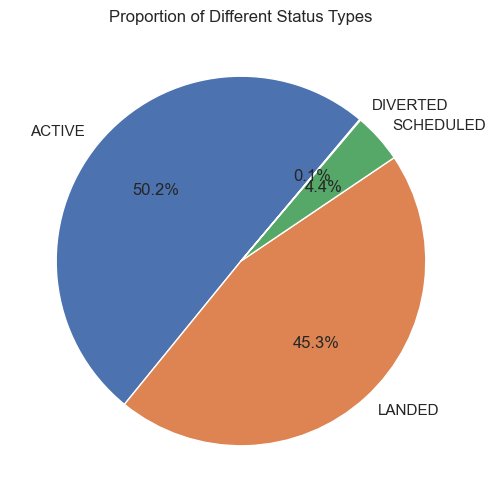

In [70]:
status_summary = get_status_summary(df)
status_proportions = status_summary['Proportions (%)']  # Extract status proportions for plotting

sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
plt.pie(status_proportions, labels=status_summary['Status'], autopct='%1.1f%%', startangle=50)
plt.title('Proportion of Different Status Types')
plt.show()

### **3.2. Flight Performance**

Visualize the **distribution** of **delayed flights** across the dataset.
- Histogram for delayed minutes
- Histogram for delayed/not delayed flights

In [71]:
flight_performance = FlightPerformance(df)
percentages = flight_performance.overall_performance() # Calculate overall performance
print("Overall Flight Performance Percentage\n")
for label, percent in percentages.items():
    print(f"{label}: {percent:.2f}%")

# Define delay ranges and labels
delay_ranges = [
    (0, 60, "0 - 60 minutes"),
    (60, 120, "60 - 120 minutes"),
    (120, 180, "120 - 180 minutes"),
    (180, None, "over 180 minutes")
]

delay_percentages = flight_performance.delayed_flight_percentages(delay_ranges) # Calculate and print delay percentages for each range
print("\nPercentage of Delayed Flights\n")
for label, percent in delay_percentages.items():
    print(f"Between {label}: {percent:.2f}%")

Overall Flight Performance Percentage

Delayed Flights: 64.05%
On-Time Flights: 32.31%
Flights with Missing Status: 3.64%

Percentage of Delayed Flights

Between 0 - 60 minutes: 91.00%
Between 60 - 120 minutes: 5.67%
Between 120 - 180 minutes: 0.82%
Between over 180 minutes: 0.44%


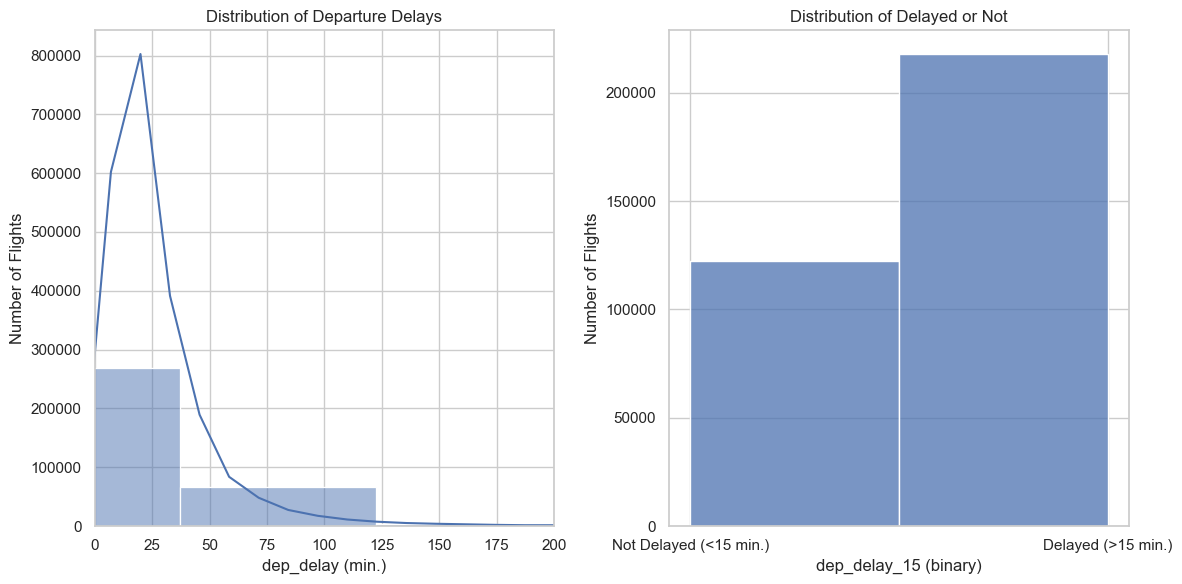

In [72]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # Distribution of dep_delay
sns.histplot(df['dep_delay'], bins=30, kde=True)  # kde=True adds a smooth curve
plt.title('Distribution of Departure Delays')
plt.xlabel('dep_delay (min.)')
plt.ylabel('Number of Flights')
plt.xlim(0, 200) 

plt.subplot(1, 2, 2) # Distribution of dep_delay_15 
sns.histplot(df['dep_delay_15'], bins=2, kde=False)  # Binary values (0 and 1)
plt.title('Distribution of Delayed or Not')
plt.xlabel('dep_delay_15 (binary)')
plt.ylabel('Number of Flights')
plt.xticks(ticks=[0, 1], labels=['Not Delayed (<15 min.)', 'Delayed (>15 min.)'])

plt.tight_layout()
plt.show()

### **3.3. Time window**
Understand how flight schedules (departure time sdt and arrival time sat) influence **delays** across different **time windows** (morning, afternoon, night)

In [73]:
dep_flight_summary = flight_summary_by_time_window(df, 'dep_time_window', summarize_delays=True)
time_window_proportions = calculate_time_window_percentages(df)
time_window_proportions

,Departure Percentages (%),Arrival Percentages (%)
Time Window,,
Morning,50.28,40.17
Afternoon,31.21,32.70
Evening,18.51,27.13


In [74]:
dep_flight_summary = flight_summary_by_time_window(df, 'dep_time_window', summarize_delays=True)
arr_flight_summary = flight_summary_by_time_window(df, 'arr_time_window', summarize_delays=True)
dep_flight_summary

,dep_time_window,total_flights,delayed_flights,dep_time_window_proportion_delayed,dep_time_window_percentage_delayed
0,Afternoon,106208,69602,0.655337,65.53%
1,Evening,62975,40192,0.638222,63.82%
2,Morning,171115,108152,0.632043,63.2%


In [75]:
arr_flight_summary

,arr_time_window,total_flights,delayed_flights,arr_time_window_proportion_delayed,arr_time_window_percentage_delayed
0,Afternoon,111278,75096,0.674850,67.49%
1,Evening,92317,59590,0.645493,64.55%
2,Morning,136703,83260,0.609058,60.91%


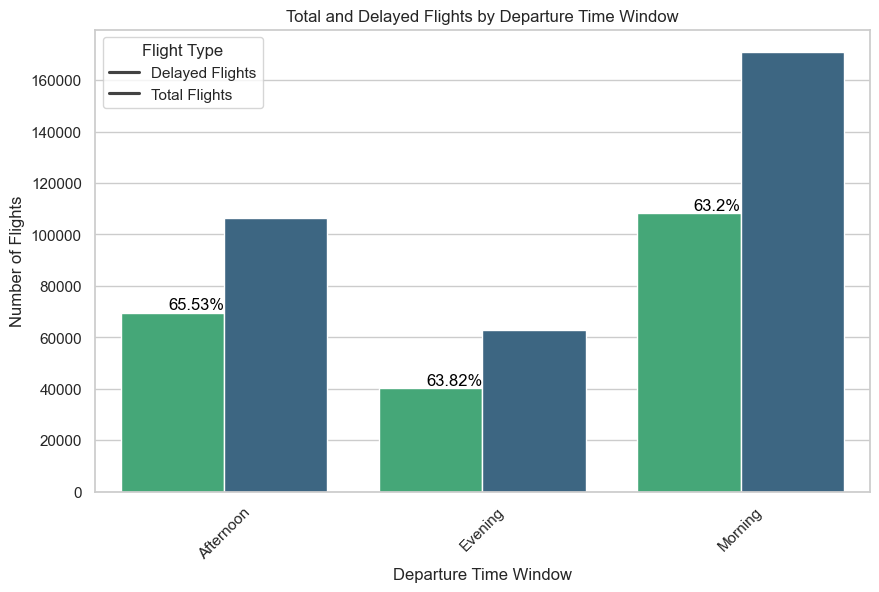

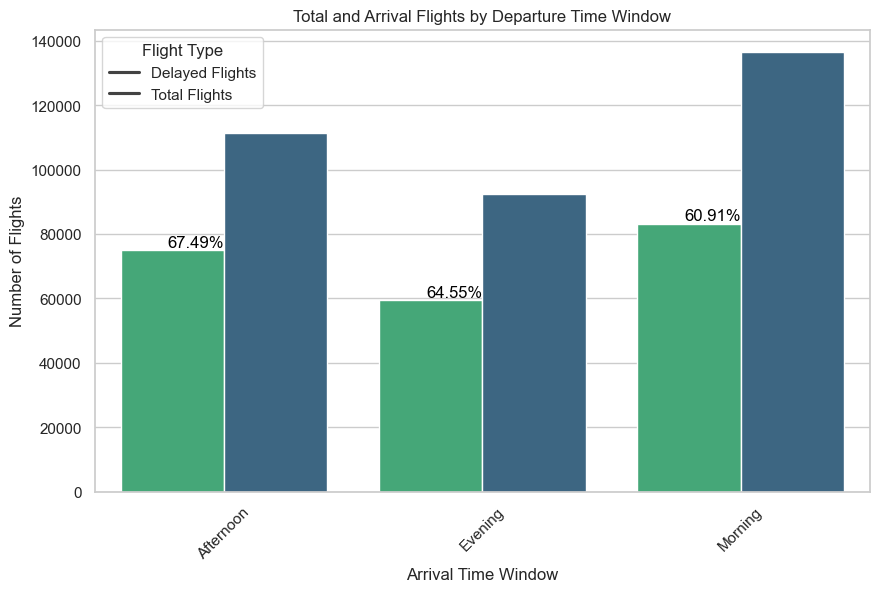

In [76]:
# New df for the bar plots
dep_bar_data = pd.melt(dep_flight_summary, id_vars='dep_time_window', value_vars=['delayed_flights', 'total_flights'],var_name='flight_type', value_name='count')
arr_bar_data = pd.melt(arr_flight_summary, id_vars='arr_time_window', value_vars=['delayed_flights', 'total_flights'],var_name='flight_type', value_name='count')

# Shift left for delayed flights and right for total flights
dep_bar_data['position'] = dep_bar_data['flight_type'].map({'delayed_flights': -0.2, 'total_flights': 0.2})
arr_bar_data['position'] = arr_bar_data['flight_type'].map({'delayed_flights': -0.2, 'total_flights': 0.2})

# Plot for Total and Delayed Arrival Flights
plt.figure(figsize=(10, 6))
ax=sns.barplot(data=dep_bar_data, x='dep_time_window', y='count', hue='flight_type', dodge=True, palette=['#35b779', '#31688e'])
for index, row in dep_flight_summary.iterrows():
    if row['delayed_flights'] > 0:  # Only display if there are delayed flights
        ax.text(index, row['delayed_flights'], f"{row['dep_time_window_percentage_delayed']}", color='black', ha='right', va='bottom', fontsize=12)
plt.title('Total and Delayed Flights by Departure Time Window')
plt.ylabel('Number of Flights')
plt.xlabel('Departure Time Window')
plt.xticks(rotation=45)
plt.legend(title='Flight Type', labels=['Delayed Flights', 'Total Flights'])
plt.show()

# Plot for Total and Delayed Departure Flights
plt.figure(figsize=(10, 6))
bx=sns.barplot(data=arr_bar_data, x='arr_time_window', y='count', hue='flight_type', dodge=True, palette=['#35b779', '#31688e'])
for index, row in arr_flight_summary.iterrows():
    if row['delayed_flights'] > 0:  # Only display if there are delayed flights
        bx.text(index, row['delayed_flights'], f"{row['arr_time_window_percentage_delayed']}", color='black', ha='right', va='bottom', fontsize=12)
plt.title('Total and Arrival Flights by Departure Time Window')
plt.ylabel('Number of Flights')
plt.xlabel('Arrival Time Window')
plt.xticks(rotation=45)
plt.legend(title='Flight Type', labels=['Delayed Flights', 'Total Flights'])
plt.show()

### **3.4. Flight Category Comparison**
Comparison of the **on-time performance** of cargo, private, & commercial flights and the **distribution** of delay times within them.

In [77]:
on_time_performance = calculate_on_time_performance(df)
flight_percentages = calculate_flight_percentages(df)

# Combine both DataFrames
combined_performance = pd.merge(on_time_performance, flight_percentages, on='Flight Category', how='left')
combined_performance

,Flight Category,Total Flights,On-Time Performance,Flight Amount Percentage
0,Cargo,20062,30.53%,5.9%
1,Commercial,315485,32.36%,92.71%
2,Private,4751,36.77%,1.4%


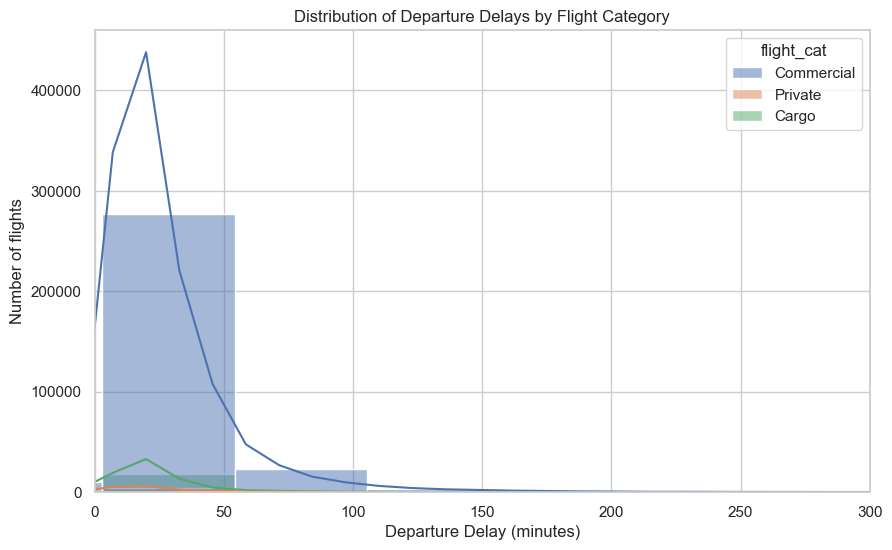

In [78]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='dep_delay', hue='flight_cat', kde=True, bins=50)
plt.xlim(0, 300)  # 300 minutes for better visualization
plt.title('Distribution of Departure Delays by Flight Category')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of flights')
plt.show()

### **3.5. Airline Delays**
The total volume of flights and the percentage of delayed flights by airlines.

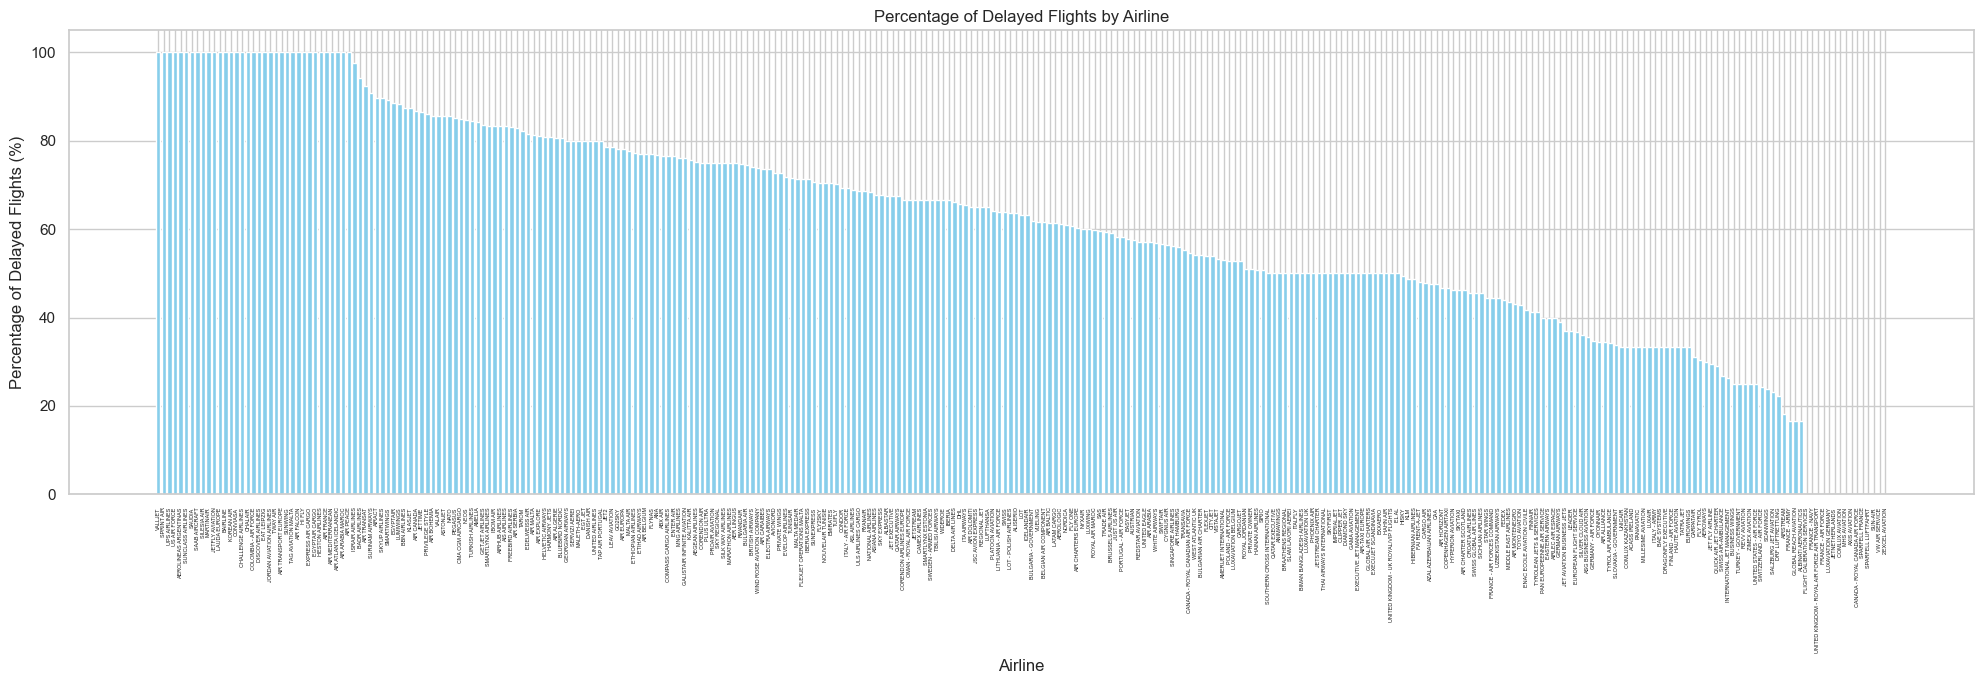

In [79]:
# Total volume of flights by airline
total_flights_airline = df.groupby('airline_name')['uuid'].count().reset_index()
total_flights_airline.columns = ['airline_name', 'total_flights']

# Delayed flights by airline
delayed_flights_airline = df[df['dep_delay_15'] == 1].groupby('airline_name')['uuid'].count().reset_index()
delayed_flights_airline.columns = ['airline_name', 'delayed_flights']

# Percentage of delayed flights
flights_summary = pd.merge(total_flights_airline, delayed_flights_airline, on='airline_name', how='left')
flights_summary['delayed_flights'] = flights_summary['delayed_flights'].fillna(0).astype(int)  # Handling NaNs
flights_summary['percent_delayed(%)'] = ((flights_summary['delayed_flights'] / flights_summary['total_flights']) * 100).round(2)

sorted_flights_summary = flights_summary.sort_values(by='percent_delayed(%)', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(20,7))
plt.bar(sorted_flights_summary['airline_name'], sorted_flights_summary['percent_delayed(%)'], color='skyblue')
plt.xticks(rotation=90, fontsize=4)
plt.xlabel('Airline')
plt.ylabel('Percentage of Delayed Flights (%)')
plt.title('Percentage of Delayed Flights by Airline')
plt.tight_layout()
plt.show()

### **3.6. Frequent Routes and Airports**
Routes and airports in Brussels with the highest percentage of delays.

                  airline_name route_iata_code  average_dep_delay
1118           EVELOP AIRLINES         BRU-VRA             564.00
1703       LUXAVIATION BELGIUM         BOO-BRU             526.00
62            AIR ARABIA MAROC         BRU-FEZ             416.00
1077        ETHIOPIAN AIRLINES         BRU-JNB             342.55
894   CORENDON AIRLINES EUROPE         HRG-BRU             340.00


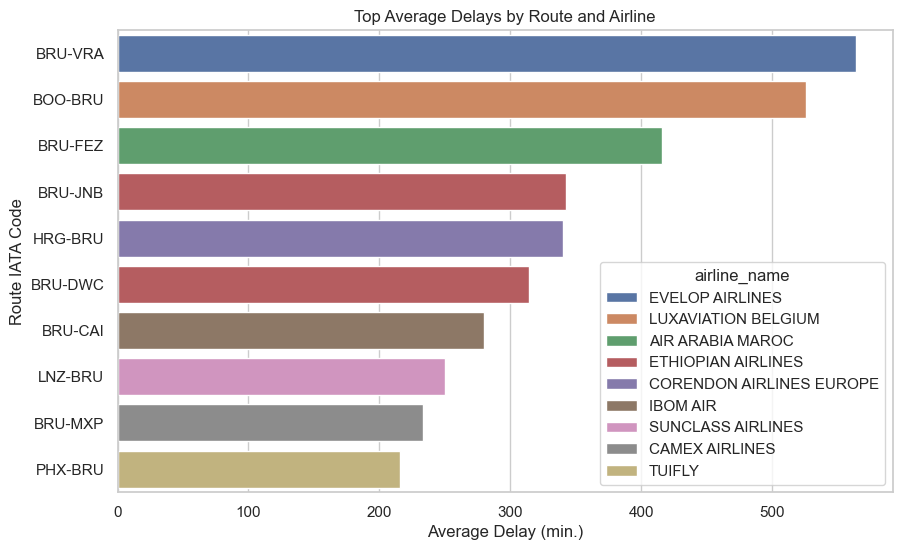

In [80]:
# Calculate and print average delays
average_delay_sorted = calculate_average_delay(df)
print(average_delay_sorted.head())

top_delays = average_delay_sorted.head(10) # Plot the top 10 average delays
plt.figure(figsize=(10, 6))
sns.barplot(x='average_dep_delay', y='route_iata_code', hue='airline_name', data=top_delays, dodge=False)
plt.title('Top Average Delays by Route and Airline')
plt.xlabel('Average Delay (min.)')
plt.ylabel('Route IATA Code')
plt.show()

### **3.7. External data (weather & passengers)**

### **3.8. EDA Results**

1. Most of the flights in the dataset are delayed. **Delayed Flights: 61.97%**
2. Most of the delays happen within the first hour. **Between 0 - 60 minutes: 88.05%**
3. Top 10 airline & route delays
4. Most flights are scheduled to depart in the morning. **Departure (Morning): 50.35%**
5. Most flights are scheduled to arrive in the morning. **Arrival (Morning): 40.07%**
6. The delay within departure flights throughout the day is similar
    * **Afternoon: 63.31%** (of the flights are delayed)
    * Evening: 62.15% 
    * Morning: 61.07% 
7. The delay within arrival flights throughout the day is similar
    * **Afternoon: 65.06%** (of the flights are delayed)
    * Evening: 62.5%
    * Morning: 58.08%
8. Most of the flights are commercial. **Commercial Flights: 92.81%**
9. The delay within departure flight throughout the day is similar
    * Cargo: 31.7%  (of the flights are delayed)
    * Commercial: 34.62%
    * **Private: 38.47%**
10. Most of the flights in the dataset are active. **Active flights: 51.04%**

## **4. Statistical Analysis**

### **4.1. Normality Test**
Many machine learning algorithms, such as linear regression, assume that variables follow a normal distribution. Testing the normality of your data helps determine if transformations are needed before modeling.

* Perform **Shapiro-Wilk Test**: It tests the null hypothesis that the data is normally distributed. If the p-value is less than 0.05, the data significantly deviates from normality. The test will be performed by taking a random sample of the data (5,000 rows) to ensure the test's validity.
* Plot a **Q-Q Plot (Quantile-Quantile plots)**: They compare the data's distribution to a normal distribution. If the data is normally distributed, the points will fall along a straight line.

### **4.2. Correlation Analysis**
Correlation analysis helps you understand the relationships between numerical variables. This can inform feature selection, detect multicollinearity, and reveal underlying patterns in your data.
* **Correlation Matrix** and **Heatmap**
* **Multicollinearity** Check with **Variance Inflation Factor (VIF)** to quantify how much the variance of each feature is inflated due to multicollinearity
    * A VIF of 1 indicates no correlation between the variable and the other variables.
    * A VIF between 1 and 5 suggests moderate correlation and is usually acceptable.
    * A VIF above 5 (and especially above 10) indicates high multicollinearity that could be problematic. 

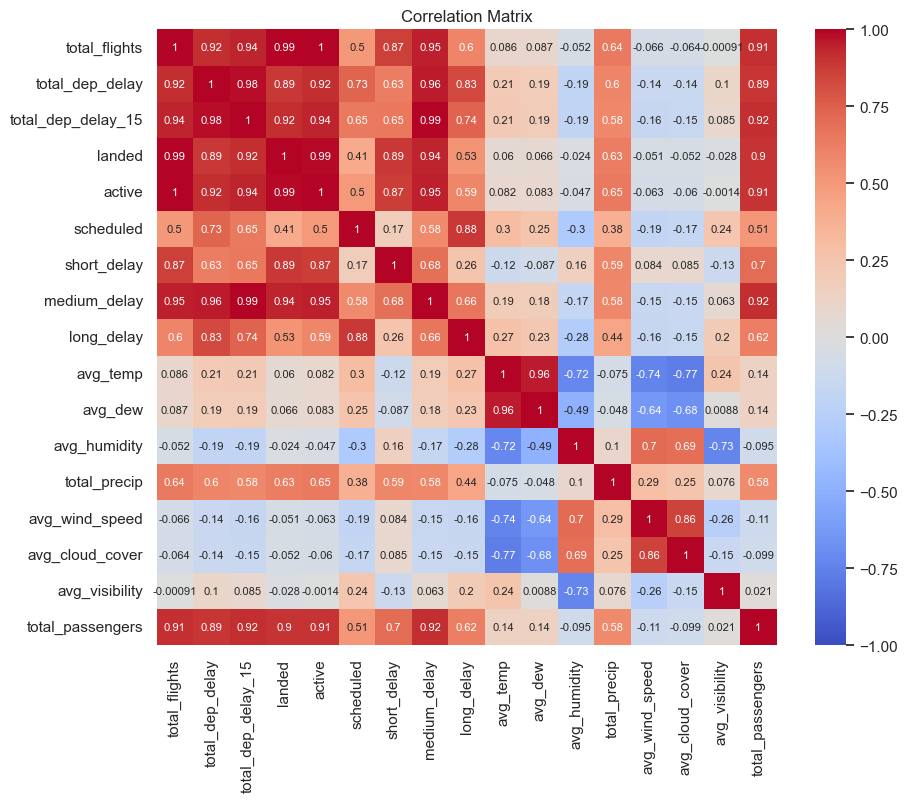

In [81]:
# Select the relevant columns for correlation analysis
corr_columns = ['total_flights', 'total_dep_delay', 'total_dep_delay_15', 'landed', 'active', 'scheduled', 'short_delay', 'medium_delay', 'long_delay', 'avg_temp', 'avg_dew', 'avg_humidity', 'total_precip', 'avg_wind_speed', 'avg_cloud_cover', 'avg_visibility', 'total_passengers']

corr_df = df_merged[corr_columns].dropna() # Drop any rows with NaN values
correlation_matrix = corr_df.corr() # Perform the correlation analysis

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8}) 
plt.title('Correlation Matrix')
plt.show()

* The target variable should be kept in the DataFrame after the VIF process but excluded from the calculations when identifying features with high multicollinearity since the target variable is needed for the modeling stage.

In [82]:
df_merged['total_passengers'] = pd.to_numeric(df_merged['total_passengers'], errors='coerce') # Convert 'total_passengers' to numeric, forcing errors to NaN
numeric_df = df_merged.select_dtypes(include=['number'])

features_to_drop = ['total_flights', 'total_dep_delay_15', 'departures', 'arrivals']
df_reduced = numeric_df.drop(columns=features_to_drop)

multicollinearity = Multicollinearity(df_reduced)
target_variable = 'total_dep_delay'
df_vif = multicollinearity.remove_high_vif_features(target_variable)
multicollinearity.df = df_vif
final_vif = multicollinearity.calculate_vif() # Display the cleaned DataFrame and final VIF values

print("Final VIF values after feature removal:")
print(final_vif)

Removing feature: medium_delay
Removing feature: avg_temp
Removing feature: active
Removing feature: avg_wind_speed
Removing feature: avg_humidity
Removing feature: landed
Removing feature: long_delay
No features above the VIF threshold.
Final VIF values after feature removal:
            feature        VIF
0   total_dep_delay  32.711124
1         scheduled   6.244211
2       short_delay   6.341724
3           avg_dew   4.076530
4      total_precip   3.336609
5   avg_cloud_cover   6.944550
6    avg_visibility   6.743461
7  total_passengers  19.510392


Results:
* Features with very high VIF values, indicate **strong multicollinearity**.

A VIF value greater than 10 is often considered indicative of multicollinearity issues, with values above 100 indicating severe multicollinearity. After removing these features, the VIF values for the remaining features have decreased significantly, indicating reduced multicollinearity.

* The **final VIF values** for the remaining features are:
    * total_dep_delay: 24.37 (remains since it is the target variable and it's needed for modeling)
    * scheduled: 5.57
    * short_delay: 7.68
    * long_delay: 14.61 (was small but got higher when adding the target variable before printing)
    * avg_dew: 4.04
    * total_precip: 3.30
    * avg_cloud_cover: 6.91
    * avg_visibility: 6.72

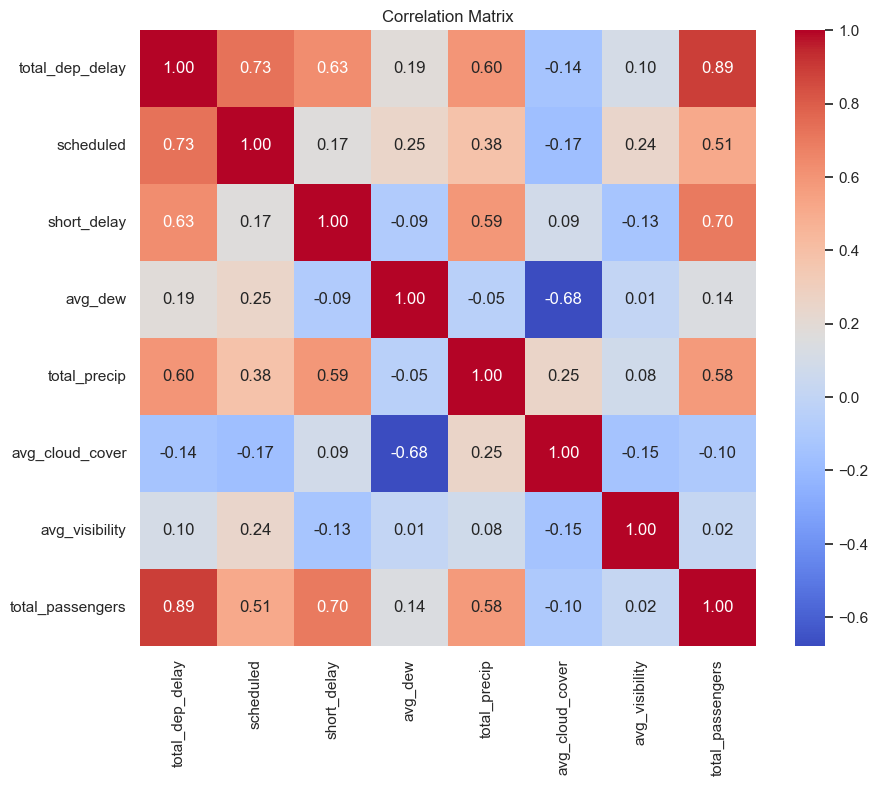

In [83]:
correlation_matrix = df_vif.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

## **5. Modelling**

### **5.1. Linear Regression (Scatter Plot)**
First, linear regression will be used since it provides a **quick initial understanding** of the relationship between the predictors (independent) and the target variable (dependent). It's useful to detect **multicollinearity** (correlation between features) and to see if a **simple model** is enough to get good results before moving to complex ones, such as Random Forest.

In [84]:
# Split the data into features (X) and target (y)
X = df_vif.drop(columns=['total_dep_delay'])  # drop the target variable
y = df_vif['total_dep_delay']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression() # Create a linear regression model
model.fit(X_train, y_train) # Fit the model on the training data
y_pred = model.predict(X_test) # Predict on the test data
mae = mean_absolute_error(y_test, y_pred) # Calculate other metrics
mse = mean_squared_error(y_test, y_pred) # Evaluate the model
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Absolute Error (MAE): 703.16
Mean Squared Error (MSE): 849966.25
R² Score: 0.90


Interpretation
**Mean Squared Error (MSE)**: It measures the average squared difference between predicted and actual values.
* A lower MSE indicates a better fit.
* MSE is 849966, so the RMSE would be √1,500,000 = 922 minutes (which is around 15 hours).
**R² Score**: It shows the proportion to which independent variables explain variance in the dependent variable.
* The values range from 0 to 1, where values closer to 1 indicate a better fit.
* 0.90 means that 90% of the variability in the target variable is explained by the model. This suggests a strong model fit, with relatively low unexplained variability.
* The average total departure delay (your target variable) ranges from 0 to 14,000 minutes, an **MAE** of 703.16 may represent approximately 5% of the total range, which could be acceptable depending on the context.

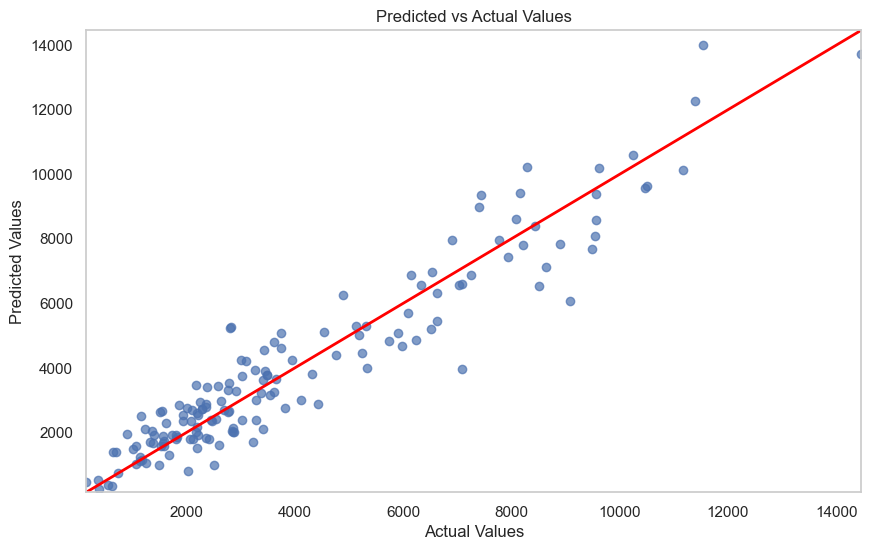

In [85]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # Diagonal line
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()

* Cross-Validation

In [86]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation
mean_mse = -np.mean(cv_scores)  # Convert from negative MSE to positive MSE
mean_r2 = np.mean(cross_val_score(model, X, y, cv=5, scoring='r2'))  # Get average r^2 score

print(f'Mean Squared Error (Cross-Validation): {mean_mse:.2f}')
print(f'R^2 Score (Cross-Validation): {mean_r2:.2f}')

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f'Mean Squared Error (Test Set): {mse_test:.2f}')
print(f'R^2 Score (Test Set): {r2_test:.2f}')

Mean Squared Error (Cross-Validation): 987527.24
R^2 Score (Cross-Validation): 0.88
Mean Squared Error (Test Set): 849966.25
R^2 Score (Test Set): 0.90


*  the cross-validation MSE, suggests that the model generalizes well and performs better on the unseen test data
*  the R^2 result suggests good performance and that the model's predictions closely match the actual values

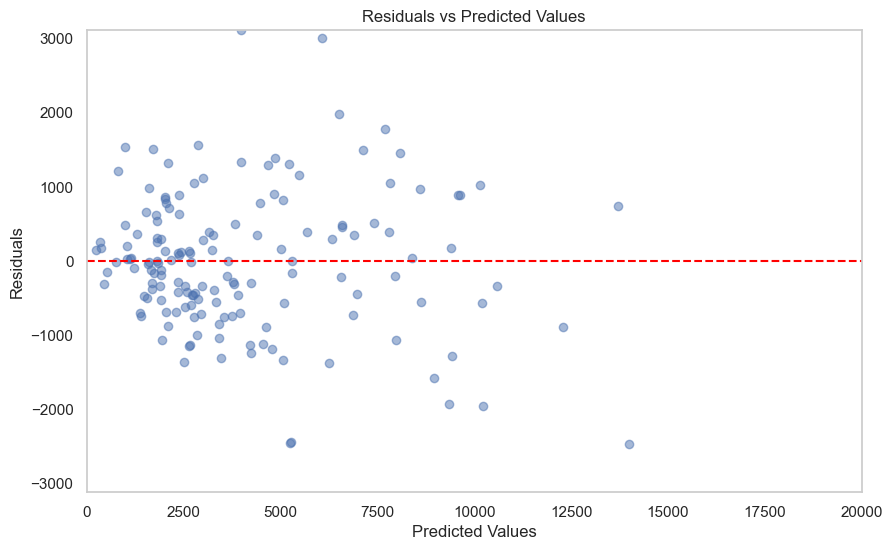

In [87]:
y_true = y_test
residuals = y_true - y_pred # Continue with residual analysis

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Add a line at zero
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.xlim(0, 20000)
plt.ylim(-max(abs(residuals)), max(abs(residuals)))
plt.grid()
plt.show()

### **5.2. Checking & Removing Outliers (Box Plot & Histogram)**
* Boxplot of the current model to **find outliers**
* **Remove** them (values above 12000)
* **Log transformation** to reduce skewness and make the distribution more normal
* Box plot to visualize any **remaining outliers**
* **Histogram** to visualize current the distribution
* Check the **model without outliers**

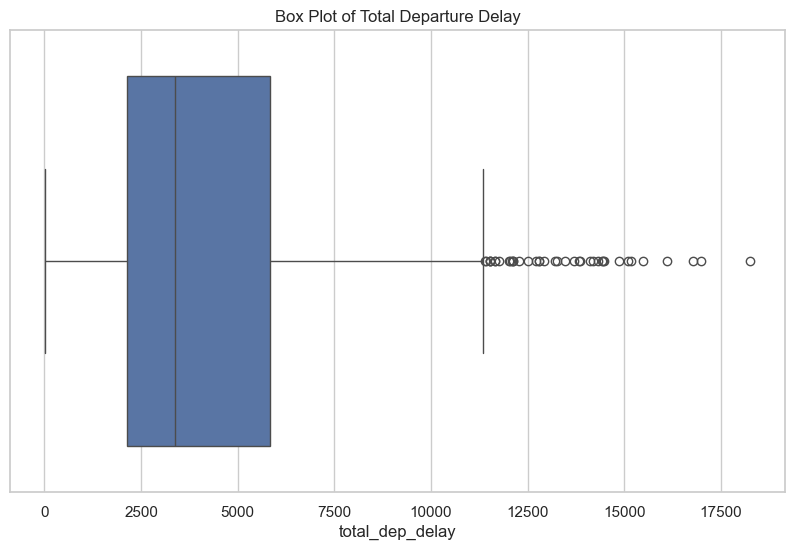

In [88]:
# Box plot to identify outliers in the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_vif['total_dep_delay'])  # Replace with your target variable
plt.title('Box Plot of Total Departure Delay')
plt.show()

* The solid line in the box indicates the **median**
* The dashed line shows the **mean**
* Points that are further away from the max are considered **extreme values** (outliers)

Q1 and Q3 values show that 50% of the data lies within 3500 min. (from just under 2500 to around 6000), indicating that most flights have relatively small delays.

* Remove outliers: Values above 12000.

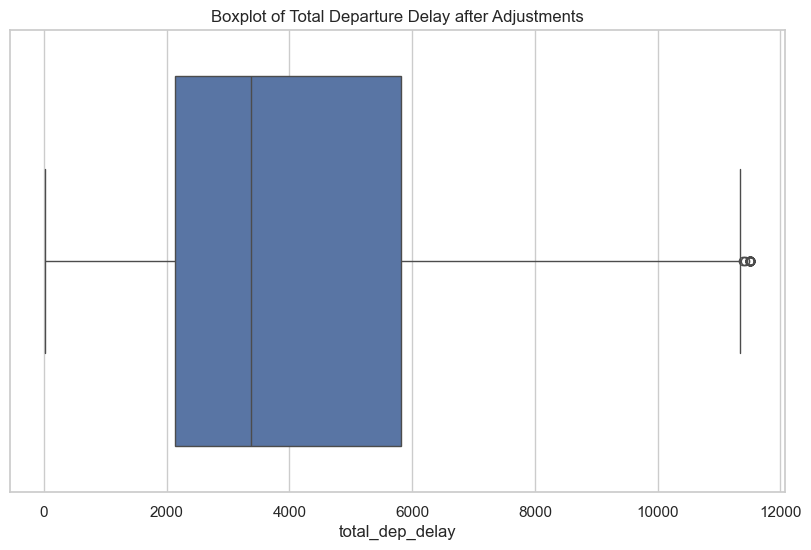

In [89]:
df_after_adj = df_vif.copy() # Copy of the dataframe to avoid warning

df_after_adj['total_dep_delay'] = df_after_adj['total_dep_delay'].clip(upper=11500) # Cap the outliers at 12000
df_after_adj['log_total_dep_delay'] = np.log1p(df_after_adj['total_dep_delay']) # Log transformation of the total departure delay

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_after_adj['total_dep_delay'])
plt.title('Boxplot of Total Departure Delay after Adjustments')
plt.show()

**Log transformation (Y=log(X))** is used to stabilize variance, reduce skewness, and make data more normally distributed. By transforming the data, we might find that the relationship between variables becomes linear, allowing for more straightforward modeling techniques.

When used with a variable (e.g., the target variable with the delay times), the range of **values are compressed**, mainly the larger ones. The model will predict values in the transformed scale (log scale). To visualize the predictions in their original scale, an exponential function will be used. 
$OriginalPredictions = e^{PredictionsLog}$

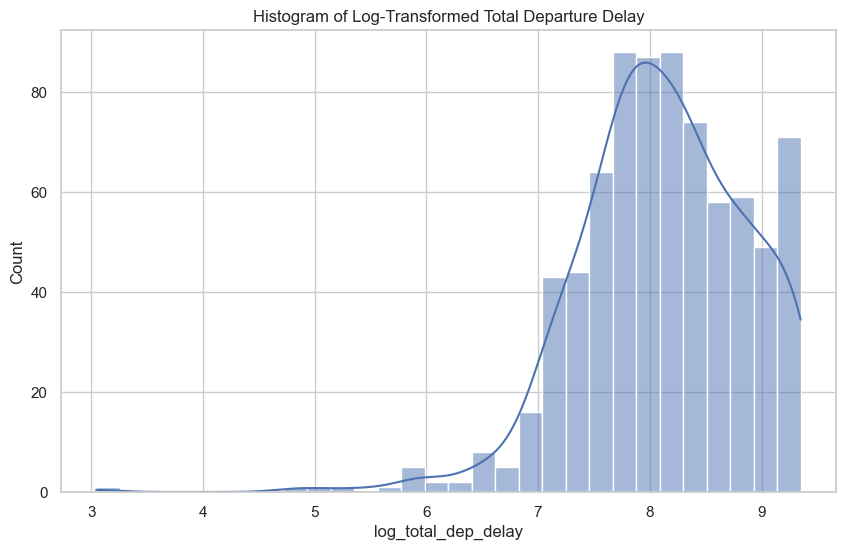

In [90]:
plt.figure(figsize=(10, 6))
sns.histplot(df_after_adj['log_total_dep_delay'], bins=30, kde=True)
plt.title('Histogram of Log-Transformed Total Departure Delay')
plt.show()

* Now lets compare two models (with and without outliers), to compare their performance. **Random Forest** will be used for this.
    * n_estimators=100 (Number of trees in the forest): This parameter specifies the number of trees in the forest. In this case, the model will build 100 decision trees, and the final prediction will be an average of the predictions from all these trees (in a regression task). A higher number of estimators generally improves performance but increases computational cost.
    * random_state=42 (Seed for reproducibility): This parameter sets the seed for the random number generator. Setting a fixed seed like 42 ensures that the random processes within the model (e.g., data sampling for each tree, random feature selection) produce the same results each time the code is run. This helps with reproducibility—if you run the code multiple times, you'll get consistent results.

In [91]:
df_no_outliers = df_after_adj[df_after_adj['log_total_dep_delay'] >= 6.8]  # New dataframe without outliers

#df_no_outliers = df_after_adj[df_after_adj['total_dep_delay'] <= 12000] 

X_no_outliers = df_no_outliers.drop(columns=['total_dep_delay', 'log_total_dep_delay']) # Split data into features and target
y_no_outliers = df_no_outliers['log_total_dep_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Train-test split for both datasets
X_no_train, X_no_test, y_no_train, y_no_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42) # Fit model with outliers
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse_with_outliers = mean_squared_error(y_test, predictions) # To evaluate performance
mae_with_outliers = mean_absolute_error(y_test, predictions)
r2_with_outliers = r2_score(y_test, predictions)

model_no_outliers = RandomForestRegressor(n_estimators=100, random_state=42) # Fit model without outliers
model_no_outliers.fit(X_no_train, y_no_train)
predictions_no_outliers = model_no_outliers.predict(X_no_test)

mse_without_outliers = mean_squared_error(y_no_test, predictions_no_outliers) # To evaluate performance
mae_without_outliers = mean_absolute_error(y_no_test, predictions_no_outliers)
r2_without_outliers = r2_score(y_no_test, predictions_no_outliers)

print("With Outliers:")
print(f'MSE: {mse_with_outliers:.2f}, MAE: {mae_with_outliers:.2f}, R²: {r2_with_outliers:.2f}')
print("Without Outliers:")
print(f'MSE: {mse_without_outliers:.2f}, MAE: {mae_without_outliers:.2f}, R²: {r2_without_outliers:.2f}')

With Outliers:
MSE: 837591.22, MAE: 713.30, R²: 0.90
Without Outliers:
MSE: 0.05, MAE: 0.17, R²: 0.90


Results
* The MSE and MAE are **much lower without outliers**, indicating that the model is making more accurate predictions.
* The R² score remained the same **0.90**.

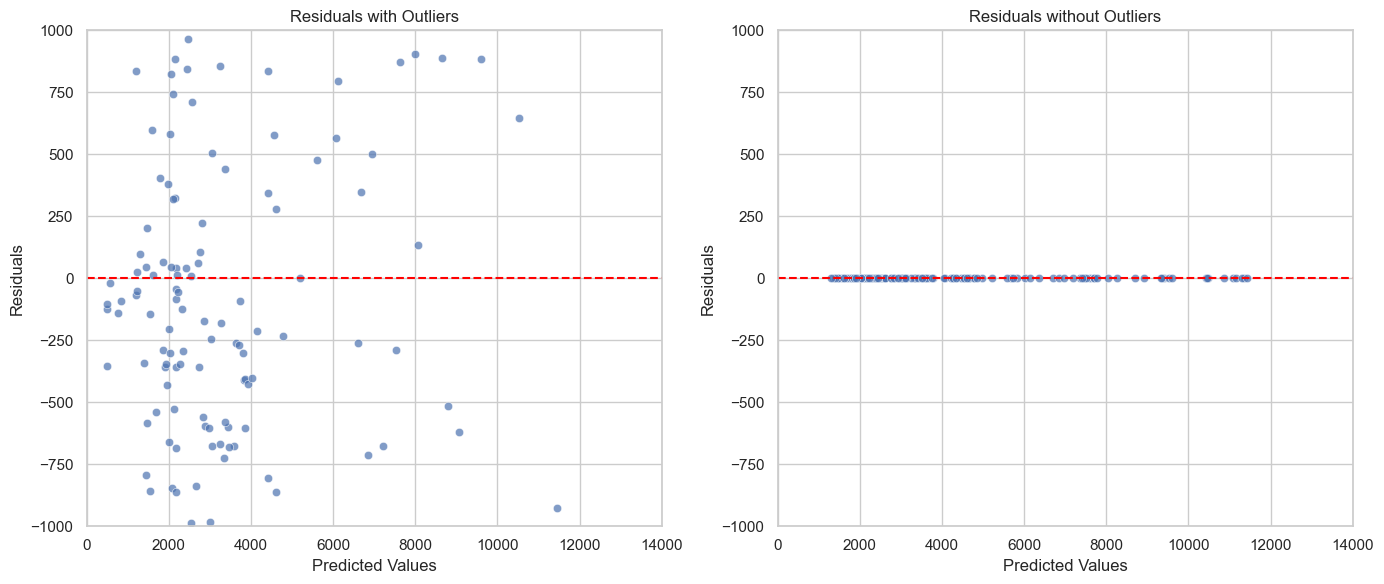

In [92]:
# Calculate residuals for both models
residuals_with_outliers = y_test - predictions
residuals_without_outliers = y_no_test - predictions_no_outliers

# Transform predictions and residuals back to original scale
original_predictions_no_outliers = np.exp(predictions_no_outliers)
original_residuals_without_outliers = np.exp(residuals_without_outliers)

# Residuals for the model with outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=predictions, y=residuals_with_outliers, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-1000,1000)
plt.xlim(0,14000)
plt.title('Residuals with Outliers')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residuals for the model without outliers
plt.subplot(1, 2, 2)
sns.scatterplot(x=original_predictions_no_outliers, y=original_residuals_without_outliers, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.ylim(-1000,1000)
plt.xlim(0,14000)
plt.title('Residuals without Outliers')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

* Scattered residuals far from the red line mean the model struggles with some parts of the data.
* Tightly clustered residuals around the red line (y = 0) indicate a good model fit.

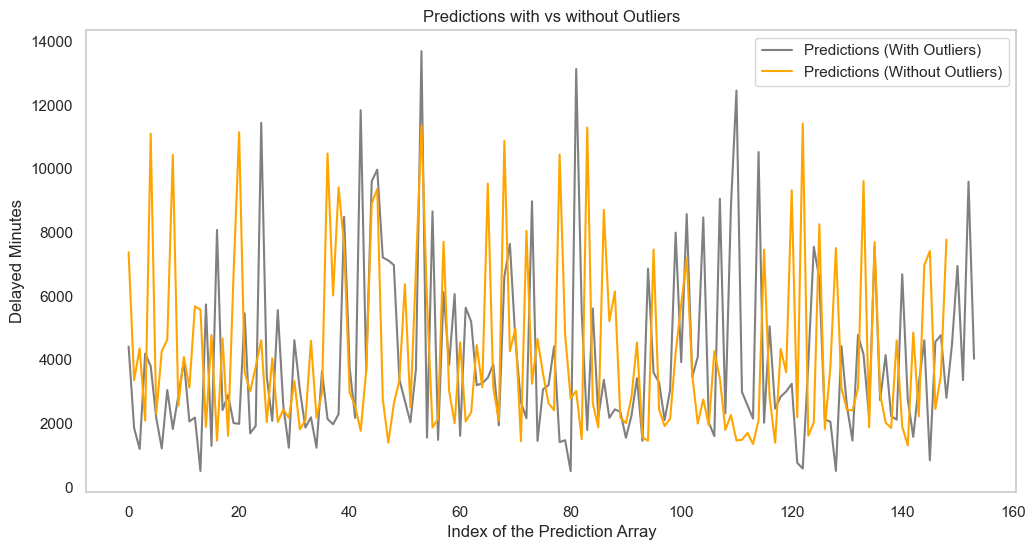

In [93]:
total_dep_delay_array = df_vif['total_dep_delay'].to_numpy()

plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predictions (With Outliers)', color='grey')#, linestyle='--', marker='x', markersize=5)
plt.plot(original_predictions_no_outliers, label='Predictions (Without Outliers)', color='orange')#, linestyle=':', marker='s', markersize=5)
plt.title('Predictions with vs without Outliers')
plt.xlabel('Index of the Prediction Array')
plt.ylabel('Delayed Minutes')
plt.legend()
plt.grid()
plt.show()

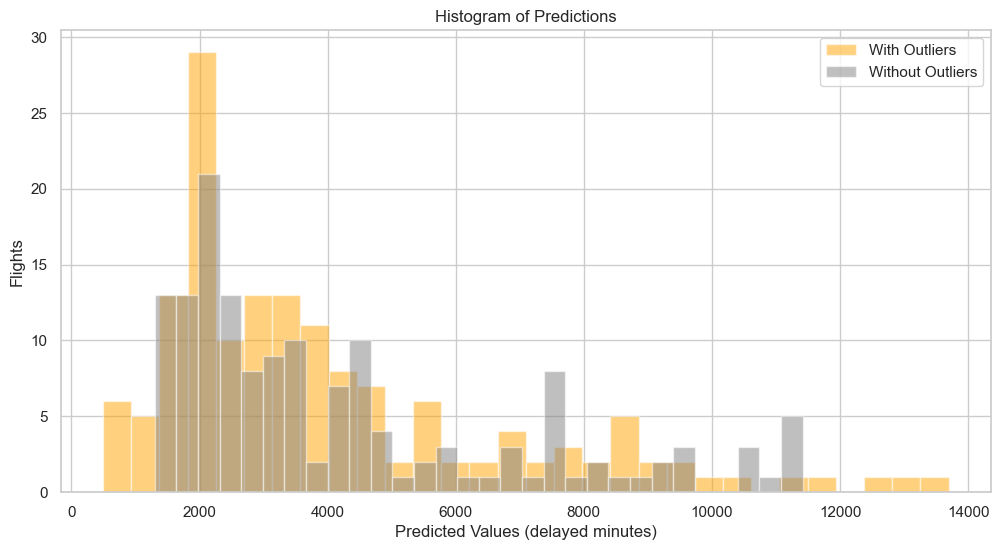

In [94]:
plt.figure(figsize=(12, 6))
plt.hist(predictions, bins=30, alpha=0.5, label='With Outliers', color='orange')
plt.hist(original_predictions_no_outliers, bins=30, alpha=0.5, label='Without Outliers', color='grey')
plt.title('Histogram of Predictions')
plt.xlabel('Predicted Values (delayed minutes)')
plt.ylabel('Flights')
plt.legend()
plt.show()

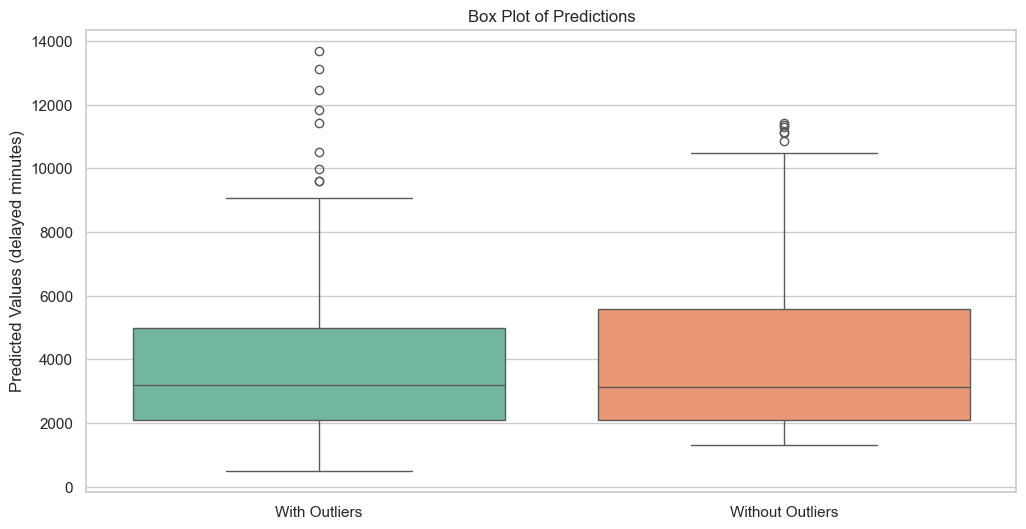

In [95]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=[predictions, original_predictions_no_outliers], palette='Set2')
plt.xticks([0, 1], ['With Outliers', 'Without Outliers'])
plt.title('Box Plot of Predictions')
plt.ylabel('Predicted Values (delayed minutes)')
plt.show()

In [96]:
total_dep_delay_array = df_vif['total_dep_delay'].to_numpy() # Convert the column with the total delayed minutes to a NumPy array

plt.figure(figsize=(12, 6))
plt.plot(actual_dep_delay_array, label='Actual Values', color='green', linewidth=2, marker='o', markersize=5)
#plt.plot(predictions, label='Predictions (With Outliers)', color='blue', linestyle='--', marker='x', markersize=5)
plt.plot(original_predictions_no_outliers, label='Predictions (Without Outliers)', color='orange', linestyle=':', marker='s', markersize=5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Amount of Flights')
plt.ylabel('Delayed Minutes')
plt.legend()
plt.grid()
plt.show()

NameError: name 'actual_dep_delay_array' is not defined

<Figure size 1200x600 with 0 Axes>

* The original dataset was **reduced** when removing outliers, therefore the amount of predicted flights is lower and our predictions dont go past 12500 delayed minutes.

### **5.3. Hyperparameter Tuning**

* Hyperparameter Tuning

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}
rf = RandomForestRegressor(random_state=42) # Initialize RandomForestRegressor
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2) # Initialize GridSearchCV
grid_search.fit(X_no_train, y_no_train) # Fit grid search to the training data without outliers
print(f"Best Parameters: {grid_search.best_params_}")

best_rf = grid_search.best_estimator_ # Train the model using the best parameters
best_rf.fit(X_no_train, y_no_train)
best_predictions_no_outliers = best_rf.predict(X_no_test) # Predict using the test set (without outliers)

# Evaluate the tuned model performance on the test set (without outliers)
best_mse_without_outliers = mean_squared_error(y_no_test, best_predictions_no_outliers)
best_mae_without_outliers = mean_absolute_error(y_no_test, best_predictions_no_outliers)
best_r2_without_outliers = r2_score(y_no_test, best_predictions_no_outliers)

print("Tuned Model Without Outliers:")
print(f'MSE: {best_mse_without_outliers:.2f}, MAE: {best_mae_without_outliers:.2f}, R²: {best_r2_without_outliers:.2f}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Model Without Outliers:
MSE: 0.04, MAE: 0.17, R²: 0.90


[0.15374621 0.04150621 0.01652252 0.04196081 0.01679266 0.02024827
 0.70922331]


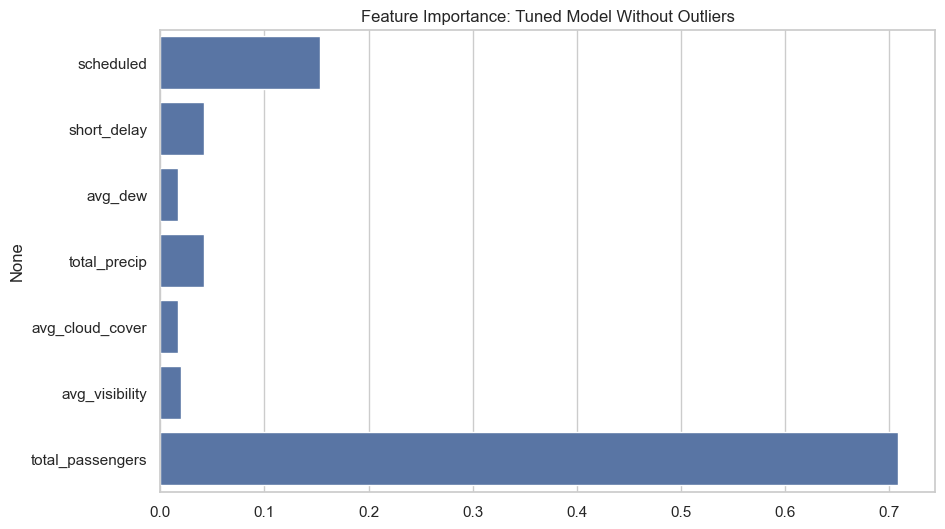

In [98]:
importances = model_no_outliers.feature_importances_
feature_names = X_no_train.columns
print(importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance: Tuned Model Without Outliers')
plt.show()